In [311]:
"""
CVaR.py>
"""
import numpy as np
import math
from scipy.optimize import minimize
from scipy.stats.distributions import chi2
from numpy import linalg
from scipy.stats import gmean
from scipy.optimize import linprog
from scipy.stats import norm
from scipy import stats

# ----- function: CVaR model ------
"""
min     gamma + (1 / [(1 - alpha) * S]) * sum( z_s )
s.t.    z_s   >= 0,                 for s = 1, ..., S
        z_s   >= -r_s' x - gamma,   for s = 1, ..., S
        1' x  =  1,
        mu' x >= R
"""

def CVaR(returns, alpha):
    mu = gmean(returns+1) - 1  # Estimate the geometric mean
    R = 1.1 * np.mean(mu)  # Set our target return
    t, p = returns.shape  # Determine the number of assets and scenarios
    # formulate the linear program
    # bound
    lst_t = np.ones(t)
    lst_p = np.ones(p)
    bounds = tuple((0, None) for i in lst_p) + tuple((0, None) for i in lst_t) + \
             tuple((-math.inf, None) for i in np.ones(1))
    # inequality constraint matrix A and vector b
    A = np.vstack((np.hstack((-returns, -np.identity(t), -np.ones((t, 1)))),
                  np.hstack((-mu[np.newaxis], np.zeros((1, t)), np.zeros((1, 1))))))
    b = np.vstack((np.zeros((t, 1)), -R[np.newaxis]))
    # equality constraint matrix Aeq and vector beq
    Aeq = np.hstack((np.ones((1, p)), np.zeros((1, t)), np.zeros((1, 1))))
    beq = 1
    # coefficient of variables
    k = 1 / ((1 - alpha) * t)
    c = np.vstack((np.zeros((p, 1)), k*np.ones((t, 1)), np.ones((1, 1))))
    # linprog optimizer
    res = linprog(c, A_ub=A, b_ub=b, A_eq=Aeq, b_eq=beq, bounds=bounds)
    x = np.asmatrix(res.x[:p])

    return x

In [312]:
"""
OLS.py>
"""

import numpy as np
from numpy.linalg import inv

# ----- function: OLS regression model ------
def OLS(returns, factRet):
    t, p = factRet.shape  # Number of observations and factors
    factRet = factRet.to_numpy(dtype=np.float64)
    returns = returns.to_numpy()
    X = np.hstack((np.ones((t, 1), dtype=np.float64), factRet))  # factor matrix;
    B = np.dot(np.dot(inv(np.dot(X.T, X)), X.T), returns)  # Regression coefficients;
    # separate B into alpha and betas
    a = B[0, :]
    V = B[1:, :]

    # residual variance
    ep = returns - np.dot(X, B)
    ep_2_sum = np.sum(ep ** 2, axis=0)  # sum each matrix column
    sigma_ep = 1 / (t - p - 1) * ep_2_sum
    D = np.diag(sigma_ep)

    # factor expected returns and covariance matrix
    f_bar = np.mean(factRet, axis=0)
    F = np.cov(factRet, rowvar=False)

    # Calc. asset expected returns and covariance matrices
    mu = a + np.dot(V.T, f_bar)
    Q = np.dot(np.dot(V.T, F), V) + D
    Q = (Q + Q.T) / 2

    # calc. adjusted R-squared
    r_bar = np.mean(returns, axis=0)
    RSS = ep_2_sum
    TSS = np.sum((returns - r_bar) ** 2, axis=0)
    R2 = 1 - RSS / TSS
    adj_R2 = 1 - (1 - R2) * ((t - 1) / (t - p - 1))
    adj_R2_bar = np.mean(adj_R2)

    return mu, Q, adj_R2_bar

In [313]:
"""
RP.py>
"""

import numpy as np
from scipy.optimize import minimize

# ----- function: Risk Parity model ------

# risk budgeting optimization
def calculate_portfolio_var(x, Q):
    # function that calculates portfolio risk
    x = np.matrix(x)
    return (x * (Q * x.T))[0, 0]

def calculate_risk_contribution(x, Q):
    # function that calculates asset contribution to total risk
    x = np.matrix(x)
    sigma = np.sqrt(calculate_portfolio_var(x, Q))
    # Marginal Risk Contribution
    MRC = Q * x.T
    # Risk Contribution
    RC = np.multiply(MRC, x.T)/sigma
    return RC

def risk_budget_objective(x, pars):
    # calculate portfolio risk
    Q = pars[0]  # covariance table
    x_targ = pars[1]  # risk target in percent of portfolio risk
    sig_p = np.sqrt(calculate_portfolio_var(x, Q))  # portfolio sigma
    risk_target = np.asmatrix(np.multiply(sig_p, x_targ))
    asset_RC = calculate_risk_contribution(x, Q)
    J = sum(np.square(asset_RC-risk_target.T))[0, 0]  # sum of squared error
    return J

def total_weight_constraint(x):
    return np.sum(x)-1.0

def long_only_constraint(x):
    return x

def RP(Q):
    p = Q.shape[0]  # number of assets
    tol = 1e-14
    x_targ = np.full(p, 1 / p)  # define initial portfolio (equal risk)
    x0 = np.random.dirichlet(np.ones(p), size=1)
    cons = ({'type': 'eq', 'fun': total_weight_constraint},
            {'type': 'ineq', 'fun': long_only_constraint})
    res = minimize(risk_budget_objective, x0=x0, args=[Q, x_targ], method='SLSQP', constraints=cons,
                   tol=tol, options={'disp': False, 'maxiter': 10000})
    x = np.asmatrix(res.x)
    return x

In [314]:
"""
robustMVO.py>
"""

import numpy as np
import math
from scipy.optimize import minimize
from scipy.stats.distributions import chi2
from numpy import linalg

# ----- function: robust MVO model ------

# model:
# min. lambda * (x' * Q * x) - mu' x + epsilon * norm (sqrtTh * x)
# s.t.  sum(x) == 1
#            x >= 0

def total_weight_constraint(x):
    return np.sum(x)-1.0

'''
def long_only_constraint(x):
    return x
'''

def sqrt_theta(Q, alpha):
    p = Q.shape[0]  # find the number of assets
    ep = math.sqrt(chi2.ppf(alpha, df=p))  # Define the radius of the uncertainty set
    theta = np.diag(np.diag(Q)) / p  # find the squared standard error of our expected returns
    sqrtTh = np.sqrt(theta)  # square root of theta
    return sqrtTh, ep

def objFn(x, pars):
    mu = pars[0]
    Q = pars[1]
    riskAver = pars[2]
    sqrtTh = pars[3]
    ep = pars[4]
    # objective function
    f = riskAver * np.dot(np.dot(x, Q), x.T) - np.dot(mu.T[np.newaxis], x.T) + ep * linalg.norm(sqrtTh * x)
    return f

def robustMVO(mu, Q, riskAver, alpha):
    p = Q.shape[0]  # find the number of assets
    sqrtTh, ep = sqrt_theta(Q, alpha)
    x0 = np.random.dirichlet(np.ones(p), size=1)[0] # initial weight
    tol = 1e-14
    cons = ({'type': 'eq', 'fun': total_weight_constraint})
    lst = np.ones(p)
    bounds = tuple((0, 1) for i in lst)
    res = minimize(objFn, x0=x0, args=[mu, Q, riskAver, sqrtTh, ep], method='SLSQP', constraints=cons,
                   bounds=bounds, tol=tol, options={'disp': False, 'maxiter': 10000})
    x = np.asmatrix(res.x)
    return x

In [315]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from openpyxl import load_workbook
import math
from datetime import datetime, timedelta
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from copulas.multivariate import VineCopula
import statsmodels.api as sm
import seaborn as sns
pd.set_option('display.max_columns', 20)

In [316]:
# ================== Robo Advisor <All Weather Global Portfolio> ==============================
dir = os.getcwd()  # wd

# 1. Link to the Robo Advisor UI and get user inputs
wb = load_workbook(dir + r'\AWGP_RoboAdvisor.xlsx')
ws = wb['UI']
name = ws[list(wb.defined_names['name'].destinations)[0][1]].value
age = ws[list(wb.defined_names['age'].destinations)[0][1]].value  # client age
cap = ws[list(wb.defined_names['cap'].destinations)[0][1]].value  # initial capital
startDate = ws[list(wb.defined_names['startDate'].destinations)[0][1]].value
injection = ws[list(wb.defined_names['injection'].destinations)[0][1]].value  # periodic injection amount
injectFreq = ws[list(wb.defined_names['injectFreq'].destinations)[0][1]].value
ESG = ws[list(wb.defined_names['ESG'].destinations)[0][1]].value  # whether to include ESG or not
ESGperc = ws[list(wb.defined_names['ESGperc'].destinations)[0][1]].value  # ESG percentage
caliYr = ws[list(wb.defined_names['caliYr'].destinations)[0][1]].value  # calibration period length
leverage = ws[list(wb.defined_names['leverage'].destinations)[0][1]].value  # percentage of leverage
reportDate = ws[list(wb.defined_names['reportDate'].destinations)[0][1]].value
rebalFreq = ws[list(wb.defined_names['rebalFreq'].destinations)[0][1]].value  # rebalancing frequency is every 6 months
cost = ws[list(wb.defined_names['cost'].destinations)[0][1]].value  # transaction cost per unit of ETF traded
countryPerc = ws[list(wb.defined_names['countryPerc'].destinations)[0][1]].value  # USD:CAD exposure. 50% means 50/50
equityFI_perc = ws[list(wb.defined_names['equityFI_perc'].destinations)[0][1]].value  # equity+FI percentage in portf
alpha = ws[list(wb.defined_names['alpha'].destinations)[0][1]].value  # confidence level
riskAver = ws[list(wb.defined_names['riskAver'].destinations)[0][1]].value  # risk tolerance

# 2. Link to the investment pool (ESG + non_ESG ETFs) and factors
# data is from 2007/01/01

# ETFs
df_ESG = pd.read_excel(dir + r'\ESG_Prices.xlsx', sheet_name='Prices', index_col=0, engine='openpyxl')
df_nonESG = pd.read_excel(dir + r'\NonESG_Prices.xlsx', sheet_name='Prices', index_col=0, engine='openpyxl')
df_nonESG = df_nonESG.loc[:, ~df_nonESG.columns.str.contains('^Unnamed')]
ret_ESG = df_ESG.pct_change().iloc[1:].loc[:reportDate]
ret_nonESG = df_nonESG.pct_change().iloc[1:].loc[:reportDate]

# select ETFs with low correlations
def select_ETF(df1, df2):
    df = df1.copy()
    cor = df.corr().abs()
    # Select upper/lower triangle of correlation matrix
    upper_triangle = cor.where(np.triu(np.ones(cor.shape), k=1).astype(bool))
    # Find features with correlation greater than 0.85
    drop_lst1 = [column for column in upper_triangle.columns if any(upper_triangle[column] > 0.8)]
    print('number of features dropped that have high correlations: ' + str(len(drop_lst1)))
    # Drop features
    df2.drop(drop_lst1, axis=1, inplace=True)
    print('number of features left: ' + str(len(df2.columns)))
    return df2

ret_ESG = select_ETF(ret_ESG.loc[:startDate], ret_ESG)
ret_nonESG = select_ETF(ret_nonESG.loc[:startDate], ret_nonESG)

# dates and tickers
dates = ret_ESG.index  # all dates of our dataset
tickers_nonESG = list(ret_nonESG.columns)
tickers_ESG = list(ret_ESG.columns)
df_ESG = pd.DataFrame(df_ESG, columns=tickers_ESG)  # ESG dataframe
df_nonESG = pd.DataFrame(df_nonESG, columns=tickers_nonESG)  # non-ESG dataframe
print("nonESG ETFs left:" + str(tickers_nonESG))
print("ESG ETFs left:" + str(tickers_ESG))


# ----- input: final selected ETFs - need to update the list manually according to the above print output ------
allocation_model = 'RP'
tickers_nonESG_equity_FI_USD = ['XNTK', 'KCE', 'XLE', 'XLV', 'XLU', 'SHY', 'TLT', 'TIP', 'LQD', 'MHWIX']
tickers_nonESG_other_USD = ['IYR', 'GLD', 'GSG']
tickers_nonESG_equity_FI_CAD = ['XIT.TO', 'XBB.TO', 'XRB.TO']
tickers_nonESG_other_CAD = ['XRE.TO']
tickers_ESG_equity_USD = ['XLB', 'SOXX']
# --------------------------------------------------------------------------------------------------------------

number of features dropped that have high correlations: 2
number of features left: 2
number of features dropped that have high correlations: 19
number of features left: 17
nonESG ETFs left:['XNTK', 'KCE', 'XLE', 'XLV', 'XLU', 'XIT.TO', 'SHY', 'TLT', 'TIP', 'LQD', 'XBB.TO', 'XRB.TO', 'IYR', 'XRE.TO', 'GLD', 'MHWIX', 'GSG']
ESG ETFs left:['XLB', 'SOXX']


portfolio value evolution:[ 98520.85482377  98109.13677577 101955.61754509 104339.38691864
 104665.6830224  105535.72284491 113876.77039541 115553.96325124
 116132.72011263 117764.69441576 117568.56157346 119755.2226169
 131365.57325134 135189.91132796 132212.09678341 129716.05588032
 128911.26116262 129351.17437328 143029.04283827 147095.03745746
 147423.20357707 148181.4818163  144959.70941994 148059.2983397
 157542.39111895 161448.88739152 161905.59251011 163890.14757096
 164969.68529476 163331.79219382 166086.44033952 169873.96613647
 167011.96518605 177650.2846224  177541.87024895 182388.07384207
 197293.02486657 193851.61890341 202126.3517825  201187.64798443
 204972.3044033  206218.93110547 217099.16226901 219898.22392223
 221982.79139063 222558.92551781 219236.7999962  198151.38813629
 231513.02191257 238005.10636492 242948.7071566  251725.75443892
 251774.67372868 246188.05600359 256118.6119726  274675.50558317
 273645.17890041 270362.92570645 273220.62108603 276242.90127729
 

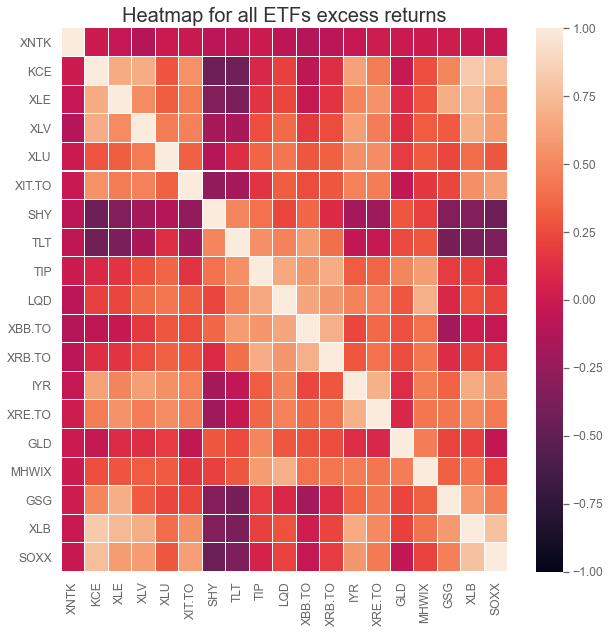

In [317]:
# factors
factors = pd.read_csv(dir + r'\FF_5_Factor.csv', index_col=0)
rf = pd.DataFrame(factors['RF'].iloc[1:], columns=['RF'])  # risk-free rate data
ret_factor = factors.drop('RF', axis=1).iloc[1:]  # factor returns data
rf.set_index(dates, inplace=True)
ret_factor.set_index(dates, inplace=True)

# CAD/USD FX rate
FX = pd.read_csv(dir + r'\USD_CAD_Historical_Data.csv', index_col=0)  # FX rate
FX.set_index(dates, inplace=True)

# Excess Return
exRet_nonESG = ret_nonESG.sub(rf['RF'], 0)  # non ESG ETFs excess return dataset
exRet_ESG = ret_ESG.sub(rf['RF'], 0)

# leverage
init_cap = cap * (1+leverage)  # total initial capital including leverage  # initial capital + leverage
loan = cap * leverage  # loan at start of investment period; interest rate = RFR

# 3. system implementation
exRet_portf = exRet_nonESG.copy()  # portfolio excess return dataset for non ESG ETFs
# separate by asset class
exRet_equity_FI_USD = pd.DataFrame(exRet_portf, columns=tickers_nonESG_equity_FI_USD)
exRet_other_USD = pd.DataFrame(exRet_portf, columns=tickers_nonESG_other_USD)
exRet_equity_FI_CAD = pd.DataFrame(exRet_portf, columns=tickers_nonESG_equity_FI_CAD)
exRet_other_CAD = pd.DataFrame(exRet_portf, columns=tickers_nonESG_other_CAD)

if ESG == 'No':
    price_portf = df_nonESG.iloc[1:].loc[:reportDate].copy()  # investment portfolio's monthly price dataset for non ESG
    # apply FX on USD non ESG ETFs price
    price_portf[tickers_nonESG_equity_FI_USD + tickers_nonESG_other_USD] = \
        price_portf[tickers_nonESG_equity_FI_USD + tickers_nonESG_other_USD].mul(FX['Price'], axis=0)
    price_portf = pd.concat([price_portf[tickers_nonESG_equity_FI_USD], price_portf[tickers_nonESG_other_USD],
                             price_portf[tickers_nonESG_equity_FI_CAD], price_portf[tickers_nonESG_other_CAD]],
                            axis=1).copy()

if ESG == 'Yes':
    price_portf = pd.concat([df_nonESG, df_ESG], axis=1).iloc[1:].loc[:reportDate].copy()  # non ESG+ESG ETFs price data
    exRet_portf = pd.concat([exRet_nonESG, exRet_ESG], axis=1).copy()  # non ESG+ESG ETFs excess return data
    # ESG ETFs returns
    exRet_ESG_equity_FI_USD = pd.DataFrame(exRet_portf, columns=tickers_ESG_equity_USD)
    # apply FX on USD ETFs for both non ESG and ESG
    price_portf[tickers_nonESG_equity_FI_USD + tickers_nonESG_other_USD + tickers_ESG_equity_USD] = \
        price_portf[tickers_nonESG_equity_FI_USD + tickers_nonESG_other_USD + tickers_ESG_equity_USD].mul(FX['Price'],
                                                                                                          axis=0)
    price_portf = pd.concat([price_portf[tickers_nonESG_equity_FI_USD], price_portf[tickers_nonESG_other_USD],
                             price_portf[tickers_nonESG_equity_FI_CAD], price_portf[tickers_nonESG_other_CAD],
                             price_portf[tickers_ESG_equity_USD]],
                            axis=1).copy()


n = exRet_portf.shape[1]  # number of ETFs in the portfolio
n_equity_FI_USD = exRet_equity_FI_USD.shape[1]  # number of USD ETFs (equity+FI)
n_other_USD = exRet_other_USD.shape[1]  # number of USD ETFs (equity+FI)
n_equity_FI_CAD = exRet_equity_FI_CAD.shape[1]  # number of CAD ETFs (equity+FI)
n_other_CAD = exRet_other_CAD.shape[1]  # number of CAD ETFs (equity+FI)
n_ESG_equity_FI_USD = exRet_ESG_equity_FI_USD.shape[1]  # number of ESG USD ETFs (equity+FI)
testStart = exRet_portf.loc[startDate:].index[0]  # each rebalancing period start date
testEnd = exRet_portf.loc[startDate:].index[6] - timedelta(days=1)   # each rebalancing period end date
caliEnd = testStart - timedelta(days=1)  # the end of each calibration period
NoPeriods = math.ceil((len(exRet_portf.loc[startDate:]) - 1) / rebalFreq)  # number of rebalancing periods
testMonths = len(exRet_portf.loc[startDate:])  # number of months in the test period
testDate = exRet_portf.loc[startDate:].index  # all dates in the test period


# Preallocate space
x_equity_FI_USD = np.zeros((n_equity_FI_USD, NoPeriods))  # USD equity + FI non ESG ETFs weight
x_other_USD = np.zeros((n_other_USD, NoPeriods))  # USD REIT + commodity non ESG ETFs weight
x_equity_FI_CAD = np.zeros((n_equity_FI_CAD, NoPeriods))  # CAD equity + FI non ESG ETFs weight
x_other_CAD = np.zeros((n_other_CAD, NoPeriods))  # CAD REIT + commodity non ESG ETFs weight
x_ESG_equity_FI_USD = np.zeros((n_ESG_equity_FI_USD, NoPeriods))  # USD ESG equity ETFs weight
x = np.zeros((n, NoPeriods))  # all ETFs weights
x0 = np.zeros((n, NoPeriods))  # all ETFs weights before rebalancing
adj_R2_bar = np.zeros(NoPeriods)
NoShares = np.zeros(n)  # all ETFs number of shares before rebalancing
NoShares_new = np.zeros(n)  # all ETFs number of shares after rebalancing
currentVal = np.zeros(NoPeriods)  # last observed portfolio value during current calibration period
portfValue = np.zeros(testMonths)  # portfolio value for each month in the test period
turnover = np.zeros(NoPeriods)
testDate2 = np.zeros(NoPeriods, dtype='datetime64[ns]')  # last day during each rebalancing period

# loop through each rebalancing period
for t in range(NoPeriods):
    # excess return of portfolio for the calibration period
    ret_cali_equity_FI_USD = exRet_equity_FI_USD.loc[caliEnd-timedelta(days=caliYr*365.25):caliEnd]
    ret_cali_other_USD = exRet_other_USD.loc[caliEnd - timedelta(days=caliYr * 365.25):caliEnd]
    ret_cali_equity_FI_CAD = exRet_equity_FI_CAD.loc[caliEnd-timedelta(days=caliYr*365.25):caliEnd]
    ret_cali_other_CAD = exRet_other_CAD.loc[caliEnd - timedelta(days=caliYr * 365.25):caliEnd]
    if ESG == 'Yes':
        ret_cali_ESG_equity_FI_USD = exRet_ESG_equity_FI_USD.loc[caliEnd - timedelta(days=caliYr * 365.25):caliEnd]

    # factors return for the calibration period
    ret_factor_cali = ret_factor.loc[caliEnd-timedelta(days=caliYr*365.25):caliEnd]

    currPrice = price_portf.loc[:caliEnd].iloc[-1]  # last observed price during calibration period
    testPrice = price_portf.loc[testStart:testEnd]  # rebalancing period prices
    testPeriod = len(price_portf.loc[testStart:testEnd])
    testDate2[t] = price_portf.loc[testStart:testEnd].index[-1].value  # last day during each rebalancing period

    if t == 0:
        # last observed portfolio value during current calibration period
        currentVal[t] = init_cap
    else:
        currentVal[t] = np.dot(currPrice, NoShares) + injection - trans_cost

        # store the current asset weights (before rebalance)
        x0[:, t] = (currPrice * NoShares) / currentVal[t]

    # portfolio construction
    # factor model: OLS calibration + optimization model, apply on each asset class
    # Risk-Parity
    if allocation_model == 'RP':
        if ESG == 'No':
            mu1, Q1, adj_R2_bar1 = OLS(ret_cali_equity_FI_USD, ret_factor_cali)
            x_equity_FI_USD[:, t] = RP(Q1) * countryPerc * equityFI_perc

            mu2, Q2, adj_R2_bar2 = OLS(ret_cali_other_USD, ret_factor_cali)
            x_other_USD[:, t] = RP(Q2) * countryPerc * (1-equityFI_perc)

            mu3, Q3, adj_R2_bar3 = OLS(ret_cali_equity_FI_CAD, ret_factor_cali)
            x_equity_FI_CAD[:, t] = RP(Q3) * countryPerc * equityFI_perc

            mu4, Q4, adj_R2_bar4 = OLS(ret_cali_other_CAD, ret_factor_cali)
            x_other_CAD[:, t] = RP(Q4) * countryPerc * (1-equityFI_perc)

        elif ESG == 'Yes':
            mu1, Q1, adj_R2_bar1 = OLS(ret_cali_equity_FI_USD, ret_factor_cali)
            x_equity_FI_USD[:, t] = RP(Q1) * (countryPerc * equityFI_perc - ESGperc)  # 20%

            mu2, Q2, adj_R2_bar2 = OLS(ret_cali_other_USD, ret_factor_cali)
            x_other_USD[:, t] = RP(Q2) * countryPerc * (1 - equityFI_perc)  # 10%

            mu3, Q3, adj_R2_bar3 = OLS(ret_cali_equity_FI_CAD, ret_factor_cali)
            x_equity_FI_CAD[:, t] = RP(Q3) * countryPerc * equityFI_perc  # 40%

            mu4, Q4, adj_R2_bar4 = OLS(ret_cali_other_CAD, ret_factor_cali)
            x_other_CAD[:, t] = RP(Q4) * countryPerc * (1 - equityFI_perc)  # 10%

            mu5, Q5, adj_R2_bar5 = OLS(ret_cali_ESG_equity_FI_USD, ret_factor_cali)
            x_ESG_equity_FI_USD[:, t] = RP(Q5) * ESGperc  # 20%
    # CVaR
    elif allocation_model == 'CVaR':
        if ESG == 'No':
            mu1, Q1, adj_R2_bar1 = OLS(ret_cali_equity_FI_USD, ret_factor_cali)
            x_equity_FI_USD[:, t] = CVaR(ret_cali_equity_FI_USD, alpha) * countryPerc * equityFI_perc

            mu2, Q2, adj_R2_bar2 = OLS(ret_cali_other_USD, ret_factor_cali)
            x_other_USD[:, t] = CVaR(ret_cali_other_USD, alpha) * countryPerc * (1 - equityFI_perc)

            mu3, Q3, adj_R2_bar3 = OLS(ret_cali_equity_FI_CAD, ret_factor_cali)
            x_equity_FI_CAD[:, t] = CVaR(ret_cali_equity_FI_CAD, alpha) * countryPerc * equityFI_perc

            mu4, Q4, adj_R2_bar4 = OLS(ret_cali_other_CAD, ret_factor_cali)
            x_other_CAD[:, t] = CVaR(ret_cali_other_CAD, alpha) * countryPerc * (1 - equityFI_perc)

        elif ESG == 'Yes':
            mu1, Q1, adj_R2_bar1 = OLS(ret_cali_equity_FI_USD, ret_factor_cali)
            x_equity_FI_USD[:, t] = CVaR(ret_cali_equity_FI_USD, alpha) * (countryPerc * equityFI_perc - ESGperc)  # 20%

            mu2, Q2, adj_R2_bar2 = OLS(ret_cali_other_USD, ret_factor_cali)
            x_other_USD[:, t] = CVaR(ret_cali_other_USD, alpha) * countryPerc * (1 - equityFI_perc)  # 10%

            mu3, Q3, adj_R2_bar3 = OLS(ret_cali_equity_FI_CAD, ret_factor_cali)
            x_equity_FI_CAD[:, t] = CVaR(ret_cali_equity_FI_CAD, alpha) * countryPerc * equityFI_perc  # 40%

            mu4, Q4, adj_R2_bar4 = OLS(ret_cali_other_CAD, ret_factor_cali)
            x_other_CAD[:, t] = CVaR(ret_cali_other_CAD, alpha) * countryPerc * (1 - equityFI_perc)  # 10%

            mu5, Q5, adj_R2_bar5 = OLS(ret_cali_ESG_equity_FI_USD, ret_factor_cali)
            x_ESG_equity_FI_USD[:, t] = CVaR(ret_cali_ESG_equity_FI_USD, alpha) * ESGperc  # 20%
    # Robust MVO
    elif allocation_model == 'robustMVO':
        if ESG == 'No':
            mu1, Q1, adj_R2_bar1 = OLS(ret_cali_equity_FI_USD, ret_factor_cali)
            x_equity_FI_USD[:, t] = robustMVO(mu1, Q1, riskAver, alpha) * countryPerc * equityFI_perc

            mu2, Q2, adj_R2_bar2 = OLS(ret_cali_other_USD, ret_factor_cali)
            x_other_USD[:, t] = robustMVO(mu2, Q2, riskAver, alpha) * countryPerc * (1 - equityFI_perc)

            mu3, Q3, adj_R2_bar3 = OLS(ret_cali_equity_FI_CAD, ret_factor_cali)
            x_equity_FI_CAD[:, t] = robustMVO(mu3, Q3, riskAver, alpha) * countryPerc * equityFI_perc

            mu4, Q4, adj_R2_bar4 = OLS(ret_cali_other_CAD, ret_factor_cali)
            x_other_CAD[:, t] = robustMVO(mu4, Q4, riskAver, alpha) * countryPerc * (1 - equityFI_perc)

        elif ESG == 'Yes':
            mu1, Q1, adj_R2_bar1 = OLS(ret_cali_equity_FI_USD, ret_factor_cali)
            x_equity_FI_USD[:, t] = robustMVO(mu1, Q1, riskAver, alpha) * (countryPerc * equityFI_perc - ESGperc)

            mu2, Q2, adj_R2_bar2 = OLS(ret_cali_other_USD, ret_factor_cali)
            x_other_USD[:, t] = robustMVO(mu2, Q2, riskAver, alpha) * countryPerc * (1 - equityFI_perc)

            mu3, Q3, adj_R2_bar3 = OLS(ret_cali_equity_FI_CAD, ret_factor_cali)
            x_equity_FI_CAD[:, t] = robustMVO(mu3, Q3, riskAver, alpha) * countryPerc * equityFI_perc

            mu4, Q4, adj_R2_bar4 = OLS(ret_cali_other_CAD, ret_factor_cali)
            x_other_CAD[:, t] = robustMVO(mu4, Q4, riskAver, alpha) * countryPerc * (1 - equityFI_perc)

            mu5, Q5, adj_R2_bar5 = OLS(ret_cali_ESG_equity_FI_USD, ret_factor_cali)
            x_ESG_equity_FI_USD[:, t] = robustMVO(mu5, Q5, riskAver, alpha) * ESGperc
    # adjusted R-square: check model fitting
    if ESG == 'No':
        adj_R2_bar[t] = (adj_R2_bar1 + adj_R2_bar2 + adj_R2_bar3 + adj_R2_bar4) / 4
        # new asset weight
        x[:, t] = np.append(np.append(np.append(x_equity_FI_USD[:, t], x_other_USD[:, t]), x_equity_FI_CAD[:, t]),
                            x_other_CAD[:, t])
        tickers = tickers_nonESG_equity_FI_USD + tickers_nonESG_other_USD + tickers_nonESG_equity_FI_CAD + \
                  tickers_nonESG_other_CAD
        # weight dataframe
        weights = pd.DataFrame(x.T, columns=tickers)
    elif ESG == 'Yes':
        adj_R2_bar[t] = (adj_R2_bar1 + adj_R2_bar2 + adj_R2_bar3 + adj_R2_bar4 + adj_R2_bar5) / 5
        x[:, t] = np.append(np.append(np.append(np.append(x_equity_FI_USD[:, t], x_other_USD[:, t]),
                                                x_equity_FI_CAD[:, t]), x_other_CAD[:, t]), x_ESG_equity_FI_USD[:, t])
        tickers = tickers_nonESG_equity_FI_USD + tickers_nonESG_other_USD + tickers_nonESG_equity_FI_CAD + \
                  tickers_nonESG_other_CAD + tickers_ESG_equity_USD
        weights = pd.DataFrame(x.T, columns=tickers)

    NoShares_new = x[:, t] * currentVal[t] / currPrice  # Number of shares to be allocated to each ETFs
    trans_cost = sum(abs(NoShares_new - NoShares) * cost)
    NoShares = NoShares_new

    # calculate the  portfolio value at each month during the test period
    for j in range(testPeriod):
        index_portf = np.where(exRet_portf.loc[startDate:].index == testStart)[0][0]
        # loan interest accumulation
        rf_7yr = 1.56  # used 7-year treasury rate from 2016-04-01 which is 1.56%
        loan_pay = loan * (1 + rf_7yr / 100) ** ((index_portf+j)/12)  # accumulated by 7-year treasury rate

        if j == 0:
            price_portf.loc[testStart]
            portfValue[index_portf+j] = np.dot(testPrice, NoShares_new)[j] - loan_pay - trans_cost
        else:
            portfValue[index_portf+j] = np.dot(testPrice, NoShares_new)[j] - loan_pay

    # calculate the turnover rate
    if t > 0:
        turnover[t] = sum(abs(x[:, t] - x0[:, t]))

    # Update the calibration and out-of-sample test periods
    if t < 9:
        testStart = exRet_portf.loc[testStart:].index[6]  # each rebalancing period start date
        testEnd = exRet_portf.loc[testStart:].index[6] - timedelta(days=1)  # each rebalancing period end date
        caliEnd = testStart - timedelta(days=1)  # the end of each calibration period
    elif t == 9:
        testStart = exRet_portf.loc[testStart:].index[6]  # each rebalancing period start date
        testEnd = exRet_portf.loc[testStart:].index[-1]  # each rebalancing period end date
        caliEnd = testStart - timedelta(days=1)  # the end of each calibration period


# outputs:
print('portfolio value evolution:' + str(portfValue.T))
print(weights)  # portfolio weighting
# print('portfolio weighting:' + str(x.T))
print('turnover:' + str(turnover))
print('adjusted R-squared:' + str(adj_R2_bar))
print('date:' + str(testDate))

# Check the correlation heatmap for our dataset
fig, ax = plt.subplots(figsize=(10,10))
corr = exRet_portf.corr()
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, linewidths=.1, vmin=-1, vmax=1)
ax.set_title('Heatmap for all ETFs excess returns', fontsize=20)
plt.show()


In [318]:
# remove injection from cashflow
portfValue_wocf = portfValue.copy()
portfPnL_wocf = np.diff(portfValue_wocf)
for i in range(len(portfPnL_wocf)):
    reb_period = np.floor(i/injectFreq)
    if i%6==5:
        portfPnL_wocf[i] = portfPnL_wocf[i] - injection
portfRet_wocf = portfPnL_wocf/portfValue_wocf[:-1]

In [319]:
# --------------------sensitivity analysis-------------------
# handling df_macro
df_macro = pd.read_excel(dir + r'\Macro_Data.xlsx', sheet_name='Index', index_col=0, engine='openpyxl')
df_macro = df_macro.drop(['AAA', 'BAA'], axis=1)
df_macro['USACPIALLMINMEI'] = df_macro['USACPIALLMINMEI'].pct_change() * 100
df_macro['INDPRO'] = df_macro['INDPRO'].pct_change() * 100
df_macro[['MCOILWTICO', 'HOUST']] = df_macro[['MCOILWTICO', 'HOUST']].pct_change() * 100

# PCA the yield curve
yieldcurve = df_macro[['GS30', 'GS20', 'GS10', 'GS5', 'GS3', 'GS1', 'GS3M']]
yieldcurve = StandardScaler().fit_transform(yieldcurve)
pca = PCA(n_components=1)
principalComponents = pca.fit_transform(yieldcurve)
principalDf = pd.DataFrame(data=principalComponents, columns=['principal component'])
df_macro['Yield Curve PCA'] = principalDf.values
df_macro = df_macro.drop(['GS30', 'GS20', 'GS10', 'GS5', 'GS3', 'GS1', 'GS3M'], axis=1)
df_macro=df_macro.iloc[1:]


In [320]:
# We tried different combinations of the economic factors for the regression with market factors
# and checked the stats like R-adjusted square and P-values for each factor. Finally, we decided to choose the
# following economic factors for the stress testing model
# We use backward elimination approach, where all variables are initially included, 
# and in each step, the most statistically insignificant variable is dropped.
# factors that dropped in the sequence of : MCOILWTICO, USACPIALLMINMEI, T10Y3MM, CBS
# at this point, all macro factors are more statistically important

In [321]:
# this is all macro factors that we select
df_macro_four = df_macro[['INDPRO', 'HOUST','UNRATE', 'Yield Curve PCA']]

In [322]:
# sensitivity analysis for the allocation model
portfRet_up=np.zeros((len(df_macro_four.columns),len(df_macro_four.columns)+2))
portfRet_down=np.zeros((len(df_macro_four.columns),len(df_macro_four.columns)+2))
portfRet_wocf = pd.DataFrame(portfRet_wocf,index=testDate[1:],columns=['portfValue'])

# macro data for the test period
df_macro_test = df_macro_four.loc[portfRet_wocf.index]
# fit model for x=macro factor returns, y=portofolio return during the test period
df_macro_test = sm.add_constant(df_macro_test)
model = sm.OLS(portfRet_wocf, df_macro_test).fit()


In [323]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             portfValue   R-squared:                       0.284
Model:                            OLS   Adj. R-squared:                  0.234
Method:                 Least Squares   F-statistic:                     5.665
Date:                Wed, 14 Jul 2021   Prob (F-statistic):           0.000655
Time:                        22:29:11   Log-Likelihood:                 144.77
No. Observations:                  62   AIC:                            -279.5
Df Residuals:                      57   BIC:                            -268.9
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -0.0242      0.010     -2.525      0.014      -0.043      -0.005
INDPRO             -0.0039      0.002     -2.104      0.040      -0.008      -0.000
HOUST               0.0008      0.000      1.852      0.069   -6.49e-05       0.002
UNRATE              0.0071      0.002      3.476      0.001       0.003       0.011
Yield Curve PCA     0.0050      0.002      2.038      0.046    8.79e-05       0.010
==============================================================================
Omnibus:                       11.781   Durbin-Watson:                   2.263
Prob(Omnibus):                  0.003   Jarque-Bera (JB):               19.945
Skew:                          -0.585   Prob(JB):                     4.67e-05
Kurtosis:                       5.520   Cond. No.                         29.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [324]:
df_macro_test

,const,INDPRO,HOUST,UNRATE,Yield Curve PCA
2016-05-01,1.0,-0.181177,-1.289768,4.8,-1.561338
2016-06-01,1.0,0.438707,4.790941,4.9,-1.882797
2016-07-01,1.0,0.181422,2.992519,4.8,-2.168130
2016-08-01,1.0,-0.176240,-5.488297,4.9,-2.041233
2016-09-01,1.0,-0.120436,-8.795901,5.0,-1.888247
...,...,...,...,...,...
2021-02-01,1.0,-2.900697,-10.953846,6.2,-2.957747
2021-03-01,1.0,2.580273,19.212163,6.0,-2.409173
2021-04-01,1.0,0.086524,-12.057971,6.1,-2.407008
2021-05-01,1.0,0.847124,3.625577,5.8,-2.431405


In [325]:
# different scenarios for the macro factor return

# normal scenario
norm_scenario = df_macro_test.median()
portfRet_norm = np.dot(np.array(norm_scenario), np.array(model.params))
print('For the normal scenario, the monthly portfolio return is {}'.format(portfRet_norm))

# up scenario for each macro factor - shocking factor return one by one
for i in range(norm_scenario.shape[0]):
    if i != 0:
        norm_scenario_up = norm_scenario.copy()
        macro_fact = norm_scenario_up.index[i]
        norm_scenario_up[macro_fact]=norm_scenario_up[macro_fact]*2
        portfRet_up[i-1,:-1] = norm_scenario_up
        portfRet_up[i-1,-1] = np.dot(np.array(norm_scenario_up), np.array(model.params))
portfRet_up_df = pd.DataFrame(portfRet_up,columns = norm_scenario.index.to_list() + ['Monthly Return'])
portfRet_up_df['AllocationModel'] = allocation_model

# down scenario for each macro factor
for i in range(norm_scenario.shape[0]):
    if i != 0:
        norm_scenario_down = norm_scenario.copy()
        macro_fact = norm_scenario_down.index[i]
        norm_scenario_down[macro_fact]=norm_scenario_down[macro_fact]*0.5
        portfRet_down[i-1,:-1] = norm_scenario_down
        portfRet_down[i-1,-1] = np.dot(np.array(norm_scenario_down), np.array(model.params))
portfRet_down_df = pd.DataFrame(portfRet_down,columns = norm_scenario.index.to_list() + ['Monthly Return'])
portfRet_down_df['AllocationModel'] = allocation_model

# Method2: use copula to simulate macro factor returns
copula = VineCopula('regular')
copula.fit(df_macro_test.drop(['const'],axis=1))
samples = copula.sample(1000)
samples.insert(0, 'constant', 1)
# Use the simulated factor returns to generate portfolio return using fitted OLS parameters
samplePortfolio = np.dot(np.array(samples), np.array(model.params))
samples['Portfolio Estimated Return'] = samplePortfolio
# best 3 up scenario and the best 3 down scenario for the simulated factor returns
upScenario1 = samples.sort_values('Portfolio Estimated Return', ascending=0).iloc[:3, :]
downScenario1 = samples.sort_values('Portfolio Estimated Return', ascending=1).iloc[:3, :]
upScenario1['AllocationModel'] = allocation_model
downScenario1['AllocationModel'] = allocation_model

print('the best 3 up scenario: {}'.format(upScenario1))
print('the best 3 down scenario: {}'.format(downScenario1))

For the normal scenario, the monthly portfolio return is 0.004801081461670253


D:\Anaconda\lib\site-packages\copulas\multivariate\vine.py:68: UserWarning: Vines have not been fully tested on Python 3.8 and might produce wrong results. Please use Python 3.5, 3.6 or 3.7
  warnings.warn(
D:\Anaconda\lib\site-packages\copulas\bivariate\base.py:160: RuntimeWarning: Data does not appear to be uniform.
  warnings.warn("Data does not appear to be uniform.", category=RuntimeWarning)


the best 3 up scenario:      constant     INDPRO      HOUST     UNRATE  Yield Curve PCA  \
799         1 -15.040188   9.799584   7.867195        -4.366267   
43          1  -0.080238  14.155307  14.549633        -3.147477   
829         1   0.077670   7.149364  14.934697        -4.128819   

     Portfolio Estimated Return AllocationModel  
799                    0.076950              RP  
43                     0.074792              RP  
829                    0.066406              RP  
the best 3 down scenario:      constant    INDPRO      HOUST    UNRATE  Yield Curve PCA  \
529         1  1.532769 -30.093450  2.064417         0.124563   
952         1 -0.409617 -23.614536  1.221379         0.484692   
214         1  1.507578 -22.497618  2.777215         0.052390   

     Portfolio Estimated Return AllocationModel  
529                   -0.039072              RP  
952                   -0.030402              RP  
214                   -0.028210              RP  


In [326]:
# formatting the 'sensitivity.xlsx' output file
if allocation_model == 'RP':
    arow=1
elif allocation_model == 'robustMVO':
    arow=6
elif allocation_model == 'CVaR':
    arow=10

# Export results to excel
from openpyxl import load_workbook
pd.read_excel(dir + r'\ESG_Prices.xlsx', sheet_name='Prices', index_col=0, engine='openpyxl')
book = load_workbook(dir + r'\sensitivity.xlsx')
writer = pd.ExcelWriter(dir + r'\sensitivity.xlsx', engine='openpyxl') 
writer.book = book

## ExcelWriter for some reason uses writer.sheets to access the sheet.
## If you leave it empty it will not know that sheet Main is already there
## and will create a new sheet.

writer.sheets = dict((ws.title, ws) for ws in book.worksheets)

portfRet_up_df.to_excel(writer,
                        sheet_name='portfRet_up_df',startrow=arow)
portfRet_down_df.to_excel(writer,
                          sheet_name='portfRet_down_df',startrow=arow)
upScenario1.to_excel(writer,
                     sheet_name='upScenario',startrow=arow)
downScenario1.to_excel(writer,
                       sheet_name='downScenario',startrow=arow)

writer.save()
writer.close()

In [327]:
def VaRCalc(returns):
    # VaR and CVaR Calculation
    
    period = 1. # horizon of 1 day
    mu_p = np.mean(returns)/30
    sig_p = np.std(returns)*np.sqrt(period/30)
    alpha = 0.01

    VaR_1 = norm.ppf(1-alpha)*sig_p - mu_p 
    value_1 =portfValue_wocf[-1]*VaR_1
    print("99% 1 day VaR :", round(VaR_1*100,2),"% or", round(value_1),"$")

    CVaR_1 = alpha**-1 * norm.pdf(norm.ppf(alpha))*sig_p - mu_p
    value_C_1 =portfValue_wocf[-1]*CVaR_1
    print("99% 1 day CVaR/ES :", round(CVaR_1*100,2),"% or", round(value_C_1),"$")

    period = 10. # horizon of 10 days
    mu_p = np.mean(returns)/30*period
    sig_p = np.std(returns) * np.sqrt(period/30)
    VaR_2 = norm.ppf(1-alpha)*sig_p - mu_p
    value_2=portfValue_wocf[-1]*VaR_2
    print("99% 10 day VaR :", round(VaR_2*100,2),"% or", round(value_2),"$")

    CVaR_2 = alpha**-1 * norm.pdf(norm.ppf(alpha))*sig_p - mu_p
    value_C_2 =portfValue_wocf[-1]*CVaR_2
    print("99% 10 day CVaR/ES :", round(CVaR_2*100,2),"% or", round(value_C_2),"$")
    
    return VaR_1, value_1, CVaR_1, value_C_1, VaR_2, value_2, CVaR_2, value_C_2 

In [328]:
# Scenario Analysis - Stress VaR
# factors
factors_all = pd.read_csv(dir + r'\FF_5_Factor_all.csv', index_col=0,parse_dates=True)
ret_factor_all = factors_all[['Mkt-RF','SMB','HML','RMW','CMA']].iloc[:-1,:]
ret_factor_test = ret_factor_all.loc[testDate]

# historical asset returns
data_all = pd.read_excel(dir + r'\Historical_Data.xlsx', sheet_name='Sheet1', index_col=0,engine='openpyxl')
data_all = data_all.pct_change()

# Calibrate OLS model on the current dataset: X=famma french 5 factor returns, y=asset excess return
scenario_coef = np.zeros((len(ret_factor_all.columns)+1,len(exRet_portf.columns)))
exRet_portf_test = exRet_portf.loc[ret_factor_test.index] # may change a bit
ret_factor_test = sm.add_constant(ret_factor_test)

for tickerindex in range(len(exRet_portf_test.columns)):
    ticker = exRet_portf_test.columns[tickerindex]
    scenario_model = sm.OLS(exRet_portf_test[ticker], ret_factor_test).fit()
    scenario_coef[:,tickerindex] = scenario_model.params
scenario_coef = pd.DataFrame(scenario_coef,columns = exRet_portf.columns) 
scenario_coef.index = ['const'] + list(ret_factor_all.columns)

# use the calibrated OLS model to generate historical asset returns
ret_factor_all = sm.add_constant(ret_factor_all)
regressed = np.dot(ret_factor_all,scenario_coef)
regressed = pd.DataFrame(regressed,columns = exRet_portf.columns)
regressed.index = ret_factor_all.index # simulated past asset return

# if historical dataset is empty, replace it with the simulated past asset return
for i in range(data_all.shape[0]): #iterate over rows
    for j in range(data_all.shape[1]): #iterate over columns
        adate = data_all.index[i]
        aticker = data_all.columns[j]
        if pd.isna(data_all.iloc[i, j]):
            data_all.iloc[i, j] = regressed.loc[adate,aticker]

# list of historical scenarios
# using the weights during the initial test period

# all historical data are simulated so it's not very reliable. skip it
# factors_AsianCrisis = ret_factor_all.loc['1998-04-01':'1998-10-01']
# AsianCrisis = np.dot(np.dot(factors_AsianCrisis,scenario_coef),weights.iloc[0])
# print('For {}:'.format('AsianCrisis'))
# VaRCalc(AsianCrisis)

techBubble = np.dot(data_all.loc['2000-03-01':'2002-09-01'],weights.iloc[0])
print('For {}:'.format('techBubble'))
VaRCalc(techBubble)

sellOff911 = np.dot(data_all.loc['2001-07-01':'2001-09-01'],weights.iloc[0])
print('For {}:'.format('sellOff911'))
VaRCalc(sellOff911)

subprimeRecession = np.dot(data_all.loc['2008-01-01':'2009-06-01'],weights.iloc[0])
print('For {}:'.format('subprimeRecession'))
VaRCalc(subprimeRecession)

Summer2011 = np.dot(data_all.loc['2011-06-01':'2011-10-01'],weights.iloc[0])
print('For {}:'.format('Summer2011'))
VaRCalc(Summer2011)

For techBubble:
99% 1 day VaR : 1.17 % or 3418 $
99% 1 day CVaR/ES : 1.34 % or 3919 $
99% 10 day VaR : 3.64 % or 10667 $
99% 10 day CVaR/ES : 4.18 % or 12251 $
For sellOff911:
99% 1 day VaR : 1.01 % or 2948 $
99% 1 day CVaR/ES : 1.14 % or 3348 $
99% 10 day VaR : 3.66 % or 10718 $
99% 10 day CVaR/ES : 4.09 % or 11982 $
For subprimeRecession:
99% 1 day VaR : 2.21 % or 6490 $
99% 1 day CVaR/ES : 2.53 % or 7424 $
99% 10 day VaR : 7.18 % or 21032 $
99% 10 day CVaR/ES : 8.18 % or 23987 $
For Summer2011:
99% 1 day VaR : 2.15 % or 6292 $
99% 1 day CVaR/ES : 2.46 % or 7207 $
99% 10 day VaR : 6.81 % or 19972 $
99% 10 day CVaR/ES : 7.8 % or 22865 $


(0.02146851347944488,
 6292.353057766424,
 0.02459037621042583,
 7207.361100592636,
 0.06813997372785018,
 19971.60969962269,
 0.07801217050014347,
 22865.119192326412)

In [329]:
# list of historical scenarios
# using the weights during the last test period
techBubble = np.dot(data_all.loc['2000-03-01':'2002-09-01'],weights.iloc[-1])
print('For {}:'.format('techBubble'))
VaRCalc(techBubble)

sellOff911 = np.dot(data_all.loc['2001-07-01':'2001-09-01'],weights.iloc[-1])
print('For {}:'.format('sellOff911'))
VaRCalc(sellOff911)

subprimeRecession = np.dot(data_all.loc['2008-01-01':'2009-06-01'],weights.iloc[-1])
print('For {}:'.format('subprimeRecession'))
VaRCalc(subprimeRecession)

Summer2011 = np.dot(data_all.loc['2011-06-01':'2011-10-01'],weights.iloc[-1])
print('For {}:'.format('Summer2011'))
VaRCalc(Summer2011)

For techBubble:
99% 1 day VaR : 1.19 % or 3501 $
99% 1 day CVaR/ES : 1.37 % or 4014 $
99% 10 day VaR : 3.73 % or 10932 $
99% 10 day CVaR/ES : 4.28 % or 12554 $
For sellOff911:
99% 1 day VaR : 0.99 % or 2910 $
99% 1 day CVaR/ES : 1.13 % or 3304 $
99% 10 day VaR : 3.62 % or 10619 $
99% 10 day CVaR/ES : 4.05 % or 11864 $
For subprimeRecession:
99% 1 day VaR : 2.2 % or 6459 $
99% 1 day CVaR/ES : 2.52 % or 7389 $
99% 10 day VaR : 7.14 % or 20941 $
99% 10 day CVaR/ES : 8.15 % or 23882 $
For Summer2011:
99% 1 day VaR : 2.08 % or 6110 $
99% 1 day CVaR/ES : 2.39 % or 6998 $
99% 10 day VaR : 6.63 % or 19434 $
99% 10 day CVaR/ES : 7.59 % or 22241 $


(0.020846695871104676,
 6110.10029336526,
 0.02387513145897143,
 6997.725137526327,
 0.06630741511564266,
 19434.492595632204,
 0.07588416932041259,
 22241.408810933182)

In [330]:
# Link to the benchmark data
df_bm = pd.read_excel(dir + r'\Benchmark.xlsx', sheet_name='Prices', index_col=0,engine='openpyxl')
df_bm_val = df_bm.loc[testDate[0:]].copy()
df_bm = df_bm.pct_change()
df_bm = df_bm.loc[testDate[1:]]
# Prepare the risk free data
rf = rf.loc[testDate[1:]]

In [331]:
# calculate the weight of each asset class for benchmark indices
# benchmark strategy: use the initial weight, buy and hold
x_equity = np.sum(x_equity_FI_USD[:5,0])+np.sum(x_equity_FI_CAD[0,0])+np.sum(x_ESG_equity_FI_USD[:,0])
x_fi = np.sum(x_equity_FI_USD[5:,0])+np.sum(x_equity_FI_CAD[1:,0])
x_REIT = np.sum(x_other_USD[0,0])+np.sum(x_other_CAD[:,0])
x_Commodity = np.sum(x_other_USD[1:,0])
ini_weight = [x_equity,x_fi,x_REIT,x_Commodity]
weighted_total_return = []
weighted_total_val = []
for i in range(df_bm.shape[0]):
    total = np.dot(df_bm.values.tolist()[i],ini_weight)
    weighted_total_return.append(total)
df_bm["Weighted Total Return"] = weighted_total_return

for i in range(df_bm_val.shape[0]):
    total_val = np.dot(df_bm_val.values.tolist()[i],ini_weight)
    weighted_total_val.append(total_val)
df_bm_val["Weighted Total Value"] = weighted_total_val

In [332]:
df_bm["Weighted Total Return"]

2016-05-01    0.008184
2016-06-01    0.012124
2016-07-01    0.019404
2016-08-01   -0.002453
2016-09-01    0.000864
                ...   
2021-02-01    0.015876
2021-03-01    0.011588
2021-04-01    0.021130
2021-05-01    0.009795
2021-05-31    0.012092
Name: Weighted Total Return, Length: 62, dtype: float64

In [333]:
# --------------------TESTING ------- sensitivity analysis for benchmark-------------------

In [334]:
# this is all macro factors that we select
df_macro_bm = df_macro[['USACPIALLMINMEI', 'T10Y3MM', 'MCOILWTICO', 
       'UNRATE']]

In [335]:
# sensitivity analysis for the allocation model
bmRet_up=np.zeros((len(df_macro_bm.columns),len(df_macro_bm.columns)+2))
bmRet_down=np.zeros((len(df_macro_bm.columns),len(df_macro_bm.columns)+2))

# macro data for the test period
df_macro_bm = df_macro_bm.loc[df_bm["Weighted Total Return"].index]
# fit model for x=macro data, y=portofolio value during the test period
df_macro_bm = sm.add_constant(df_macro_bm)
model = sm.OLS(df_bm["Weighted Total Return"], df_macro_bm).fit()

In [336]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                             
=================================================================================
Dep. Variable:     Weighted Total Return   R-squared:                       0.213
Model:                               OLS   Adj. R-squared:                  0.157
Method:                    Least Squares   F-statistic:                     3.850
Date:                   Wed, 14 Jul 2021   Prob (F-statistic):            0.00775
Time:                           22:29:19   Log-Likelihood:                 167.71
No. Observations:                     62   AIC:                            -325.4
Df Residuals:                         57   BIC:                            -314.8
Df Model:                              4                                         
Covariance Type:               nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -0.0025      0.007     -0.369      0.713      -0.016       0.011
USACPIALLMINMEI     0.0050      0.009      0.569      0.572      -0.013       0.023
T10Y3MM            -0.0022      0.004     -0.588      0.559      -0.010       0.005
MCOILWTICO          0.0004      0.000      2.463      0.017    7.81e-05       0.001
UNRATE              0.0018      0.001      1.731      0.089      -0.000       0.004
==============================================================================
Omnibus:                        4.194   Durbin-Watson:                   2.318
Prob(Omnibus):                  0.123   Jarque-Bera (JB):                3.785
Skew:                          -0.303   Prob(JB):                        0.151
Kurtosis:                       4.048   Cond. No.                         64.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [337]:
# --------------------TESTING END-------------------

Portfolio Performance Measure

In [338]:
# Calculate Kurtosis and Skewness
#df_portfValue = pd.DataFrame(portfValue_wocf, index = testDate)
#df_portfReturn = df_portfValue.pct_change().iloc[1:]
kurtosis = stats.kurtosis(portfRet_wocf)
skewness = stats.skew(portfRet_wocf)
print("Kurtosis:", round(kurtosis[0],5))
print("Skewness:", round(skewness[0],5))

Kurtosis: 5.39528
Skewness: 0.30515


In [339]:
# Calculate the Return, Volatility, Correlation with Benchmark, Information Ratio and Sharpe Ratio
#AnnRet = np.mean(df_portfReturn.iloc[:,0]) * 12
#AnnVol = np.std(df_portfReturn.iloc[:,0])*math.sqrt(12)
#Corr = np.corrcoef(df_portfReturn.iloc[:,0], df_bm.iloc[:,-1])[0][1]
#PortExcessRet1 = df_portfReturn.iloc[:,0]-df_bm.iloc[:,-1]
#PortExcessRet2 = df_portfReturn.iloc[:,0]-rf.iloc[:,0]
#InformationRatio = np.mean(PortExcessRet1)/np.std(PortExcessRet1)*math.sqrt(12)
# SharpeRatio = np.mean(PortExcessRet2)/np.std(PortExcessRet2)*math.sqrt(12)
#Vol_downside = np.std(df_portfReturn[df_portfReturn.iloc[:,0]<0].iloc[0])
#if Vol_downside !=0:
    #SortinoRatio = np.mean(PortExcessRet2)/np.std(Vol_downside)*math.sqrt(12)
    #print("SortinoRatio", round(SortinoRatio,2))
    
TotalReturn = np.prod(1+portfRet_wocf.iloc[:,0])-1
annualret=(np.prod(1+portfRet_wocf.iloc[:,0])**(1/len(portfRet_wocf.iloc[:,0]))-1)*12
stdret= np.std(portfRet_wocf.iloc[:,0], ddof=1)*np.sqrt(12)
Corr = np.corrcoef(portfRet_wocf.iloc[:,0], df_bm.iloc[:,-1])[0][1]
Sharpe = (annualret-0.0156)/stdret 
TotalBenchmarkReturn = np.prod(1+df_bm.iloc[:,-1])-1
annualbret = (np.prod(1+df_bm.iloc[:,-1])**(1/len(df_bm.iloc[:,-1]))-1)*12
TrackingError = np.std(portfRet_wocf.iloc[:,0]-df_bm.iloc[:,-1])*np.sqrt(12)
InfoRatio = (annualret-annualbret)/TrackingError

print("Annualized Return", round(annualret,2))
print("Annualized Volatility", round(stdret,2))
print("Correlation with Benchmark", round(Corr,2))
print("Tracking Error", round(TrackingError,2))
print("Information Ratio", round(InfoRatio,2))
print("Sharpe Ratio", round(Sharpe,2))

Annualized Return 0.1
Annualized Volatility 0.1
Correlation with Benchmark 0.7
Tracking Error 0.07
Information Ratio 0.36
Sharpe Ratio 0.84


In [340]:
#Calculate Max Drawdown
import quantstats as qs
max_drawdown=qs.stats.max_drawdown(portfRet_wocf.iloc[:,0])
print("max_drawdown", round(max_drawdown,2))

max_drawdown -0.11


In [341]:
# Calculate VaR and CVaR
VaRCalc(portfRet_wocf.iloc[:,0])

99% 1 day VaR : 1.15 % or 3365 $
99% 1 day CVaR/ES : 1.32 % or 3867 $
99% 10 day VaR : 3.44 % or 10073 $
99% 10 day CVaR/ES : 3.98 % or 11661 $


(0.011480045063955342,
 3364.7647160404877,
 0.013193491036530268,
 3866.9702839840857,
 0.03436859387081978,
 10073.325614334855,
 0.03978698579179894,
 11661.439062655065)

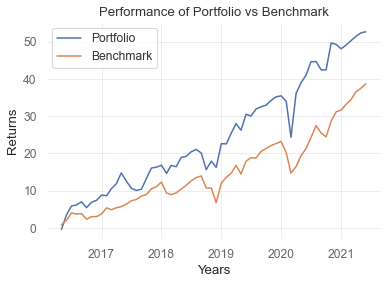

In [342]:
# Plot return of portfolio vs return of benchmark
plt.plot(portfRet_wocf.iloc[:,0].cumsum()*100,label="Portfolio")
plt.plot(df_bm.iloc[:,-1].cumsum()*100,label="Benchmark")
plt.xlabel("Years")
plt.ylabel("Returns")
plt.legend()
plt.title("Performance of Portfolio vs Benchmark")
plt.show()

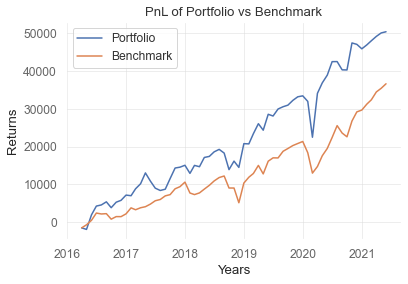

In [343]:
# Plot PnL of portfolio vs PnL of benchmark
pnl_portf = np.append((portfValue_wocf[0] - cap), portfRet_wocf * portfValue_wocf[0]).cumsum()
pnl_bm = np.append((portfValue_wocf[0] - cap), df_bm.iloc[:,-1]*portfValue_wocf[0]).cumsum()
plt.plot(testDate, pnl_portf,label="Portfolio")
plt.plot(testDate, pnl_bm,label="Benchmark")
plt.xlabel("Years")
plt.ylabel("Returns")
plt.legend()
plt.title("PnL of Portfolio vs Benchmark")
plt.show()

In [344]:
np.append((portfValue_wocf[0] - cap), portfRet_wocf * portfValue_wocf[0]).cumsum()

array([-1479.14517623, -1890.86322423,  1971.75942144,  4275.222458  ,
        4583.3225151 ,  5402.28308144,  3853.59976331,  5304.62856652,
        5798.07439144,  7182.55503772,  7018.47211474,  8850.86431489,
       10175.67602334, 13043.83277947, 10873.72384491,  9013.74212288,
        8402.49116395,  8738.69628034, 11539.95994768, 14340.6866927 ,
       14560.48477146, 15067.23146066, 12925.18397506, 15031.79795213,
       14687.84021477, 17130.81032209, 17409.50520449, 18617.12291558,
       19266.07577175, 18287.91649281, 13917.55938966, 16164.28271288,
       14504.42401555, 20780.00028094, 20719.87610625, 23409.11284784,
       26058.62801417, 24340.11689339, 28545.56929712, 28088.02430214,
       29941.35669773, 30540.55339751, 30961.08281355, 32231.31317233,
       33165.26054699, 33420.96156934, 31950.3458865 , 22474.96218821,
       34090.36469115, 36853.08492412, 38899.46024498, 42458.73911995,
       42477.88523495, 40291.8101    , 40264.01961574, 47402.27875007,
      

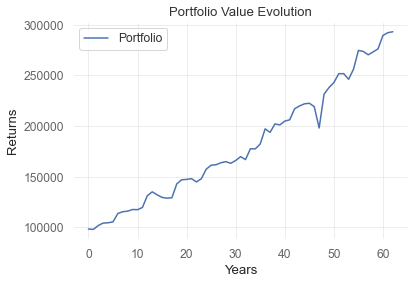

In [345]:
# Portfolio Value Evolution
plt.plot(portfValue,label="Portfolio")
plt.xlabel("Years")
plt.ylabel("Returns")
plt.legend()
plt.title("Portfolio Value Evolution")
plt.show()

In [346]:
#Measure Beta and alpha
(beta, alpha) = stats.linregress(list(df_bm.iloc[:, -1]), list(portfRet_wocf.iloc[:,0].dropna()))[0:2]
print ("Beta:", round(beta, 2))
print ("Alpha:", round(alpha*12*100, 2))

Beta: 1.06
Alpha: 2.23


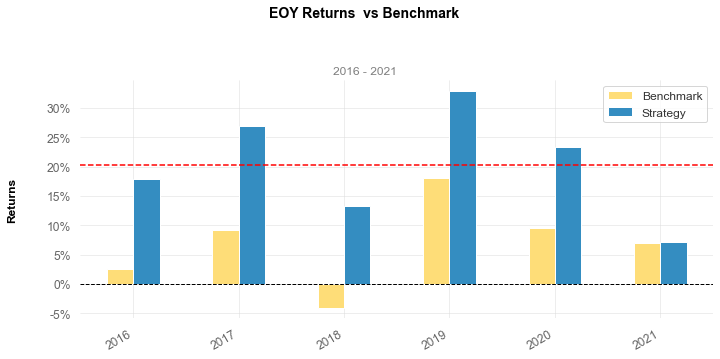

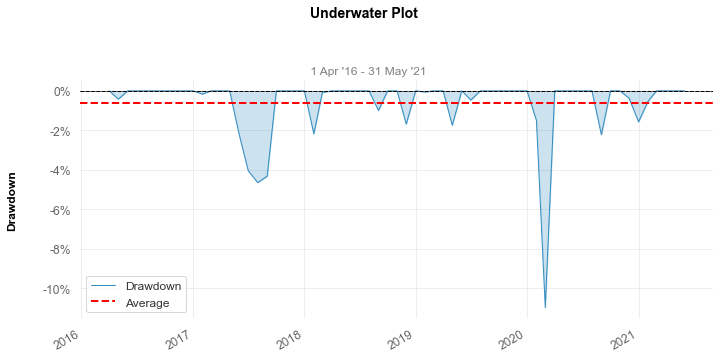

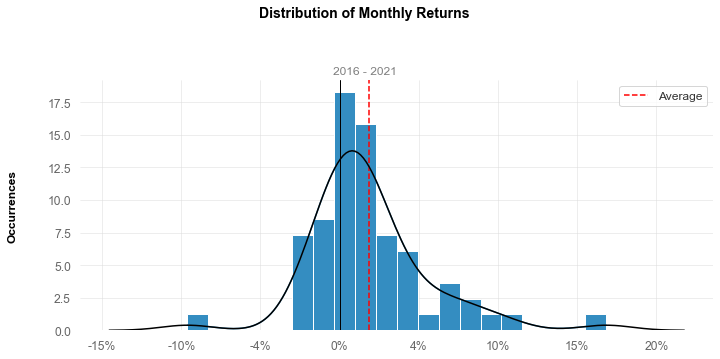

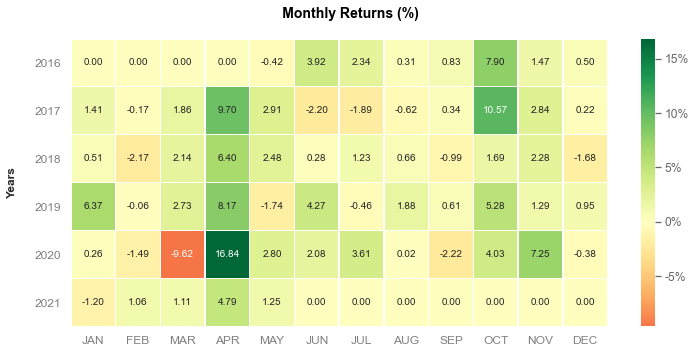

In [347]:
# Use quantstats to plot performance analysis - for reference
df_pfv = pd.DataFrame(portfValue_wocf, index = testDate)
qs.plots.yearly_returns(df_pfv.iloc[:, 0],df_bm_val.iloc[:, -1])  # EOY Returns
qs.plots.drawdown(df_pfv.iloc[:, 0])  # drawdowns
qs.plots.histogram(df_pfv.iloc[:, 0])  # return distribution
qs.plots.monthly_heatmap(df_pfv.iloc[:, 0])  # monthly return heatmap

In [348]:
# Separate into different classes based on currencies, ESG or Non-ESG, and assets and get the corresponding weights
tickers_nonESG_equity_USD = ['XNTK', 'KCE', 'XLE', 'XLV', 'XLU']
tickers_nonESG_FI_USD = ['SHY', 'TLT', 'TIP', 'LQD', 'MHWIX']
tickers_nonESG_REIT_USD = ['IYR']
tickers_nonESG_Commodity_USD = [ 'GLD', 'GSG']
tickers_nonESG_equity_CAD = ['XIT.TO']
tickers_nonESG_FI_CAD = ['XBB.TO', 'XRB.TO']
tickers_nonESG_REIT_CAD = ['XRE.TO']
tickers_ESG_equity_USD = ['XLB', 'SOXX']

weights_asset_class = pd.DataFrame()
weights_asset_class["tickers_nonESG_equity_USD"] = weights[tickers_nonESG_equity_USD].sum(axis=1)
weights_asset_class["tickers_nonESG_FI_USD"] = weights[tickers_nonESG_FI_USD].sum(axis=1)
weights_asset_class["tickers_nonESG_REIT_USD"] = weights[tickers_nonESG_REIT_USD].sum(axis=1)
weights_asset_class["tickers_nonESG_Commodity_USD"] = weights[tickers_nonESG_Commodity_USD].sum(axis=1)
weights_asset_class["tickers_nonESG_equity_CAD"] = weights[tickers_nonESG_equity_CAD].sum(axis=1)
weights_asset_class["tickers_nonESG_FI_CAD"] = weights[tickers_nonESG_FI_CAD].sum(axis=1)
weights_asset_class["tickers_nonESG_REIT_CAD"] = weights[tickers_nonESG_REIT_CAD].sum(axis=1)
weights_asset_class["tickers_ESG_equity_USD"] = weights[tickers_ESG_equity_USD].sum(axis=1)
weights_asset_class=weights_asset_class.set_index(testDate2)

AxesSubplot(0.125,0.2;0.775x0.68)


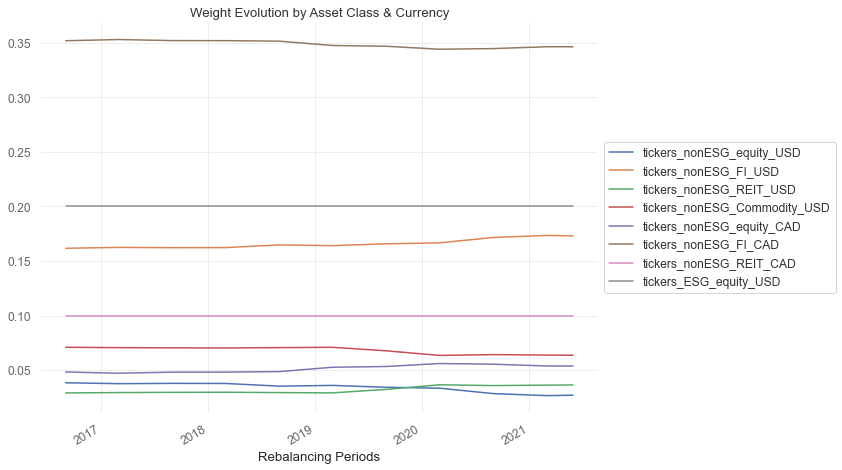

In [349]:
# Plot the weight evolution
x = weights_asset_class.plot.line(figsize=[10,8], title = "Weight Evolution by Asset Class & Currency", xlabel = "Rebalancing Periods")
x.legend(loc='center left', bbox_to_anchor=(1, 0.5))
print(x)

###################Return Attribution###################
                                  0
tickers_nonESG_equity_USD      2.13
tickers_nonESG_FI_USD         17.87
tickers_nonESG_REIT_USD        4.01
tickers_nonESG_Commodity_USD   5.99
tickers_nonESG_equity_CAD      5.65
tickers_nonESG_FI_CAD         34.35
tickers_nonESG_REIT_CAD       10.00
tickers_ESG_equity_USD        20.00


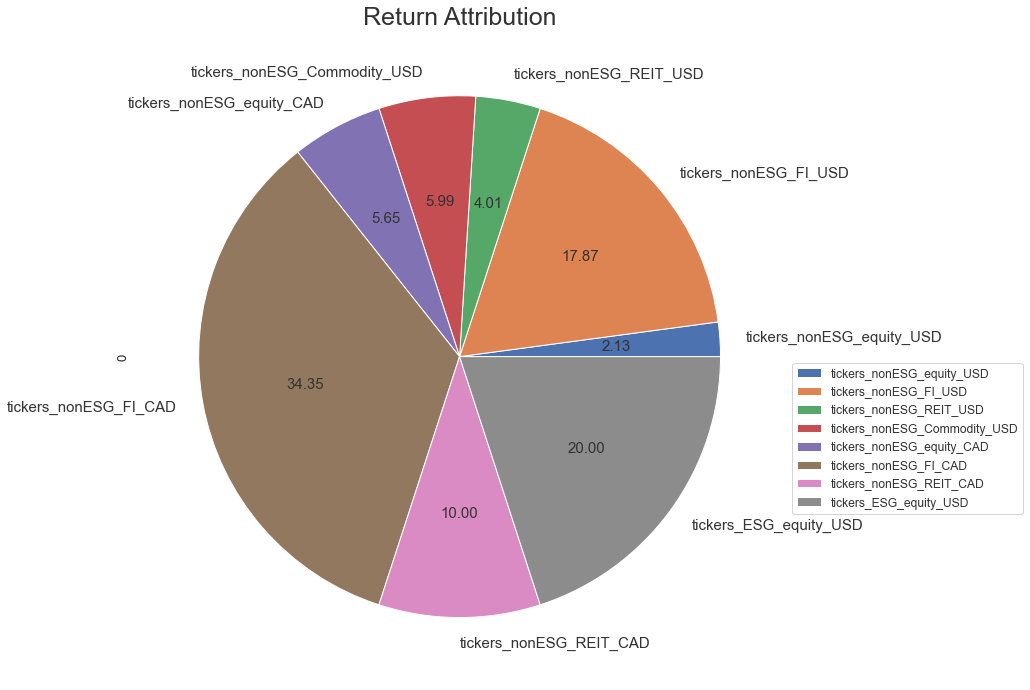

In [350]:
#Return Attribution version 1 - not consider injection
ret_contribution = (portfValue_wocf[-1]*weights.iloc[-1]-portfValue_wocf[0]*weights.iloc[0])/np.sum(portfValue_wocf[-1]*weights.iloc[-1]-portfValue_wocf[0]*weights.iloc[0])
ret_contribution = pd.DataFrame(ret_contribution).T
retc_asset_class = pd.DataFrame()
retc_asset_class["tickers_nonESG_equity_USD"] = ret_contribution[tickers_nonESG_equity_USD].sum(axis=1)
retc_asset_class["tickers_nonESG_FI_USD"] = ret_contribution[tickers_nonESG_FI_USD].sum(axis=1)
retc_asset_class["tickers_nonESG_REIT_USD"] = ret_contribution[tickers_nonESG_REIT_USD].sum(axis=1)
retc_asset_class["tickers_nonESG_Commodity_USD"] = ret_contribution[tickers_nonESG_Commodity_USD].sum(axis=1)
retc_asset_class["tickers_nonESG_equity_CAD"] = ret_contribution[tickers_nonESG_equity_CAD].sum(axis=1)
retc_asset_class["tickers_nonESG_FI_CAD"] = ret_contribution[tickers_nonESG_FI_CAD].sum(axis=1)
retc_asset_class["tickers_nonESG_REIT_CAD"] = ret_contribution[tickers_nonESG_REIT_CAD].sum(axis=1)
retc_asset_class["tickers_ESG_equity_USD"] = ret_contribution[tickers_ESG_equity_USD].sum(axis=1)

print ("###################Return Attribution###################")
returnAttribution = retc_asset_class.T
print (round(returnAttribution*100,2))
returnAttribution.plot.pie(autopct='%.2f',fontsize=15, figsize=(15, 12),subplots=True)
plt.title("Return Attribution",fontsize=25)
plt.legend(loc='upper left', bbox_to_anchor=(1, 0.5))
plt.show()

###################Risk Attribution###################
                                  0
tickers_nonESG_equity_USD      3.48
tickers_nonESG_FI_USD          7.49
tickers_nonESG_REIT_USD        6.39
tickers_nonESG_Commodity_USD   6.46
tickers_nonESG_equity_CAD      8.34
tickers_nonESG_FI_CAD         14.37
tickers_nonESG_REIT_CAD       13.94
tickers_ESG_equity_USD        39.51


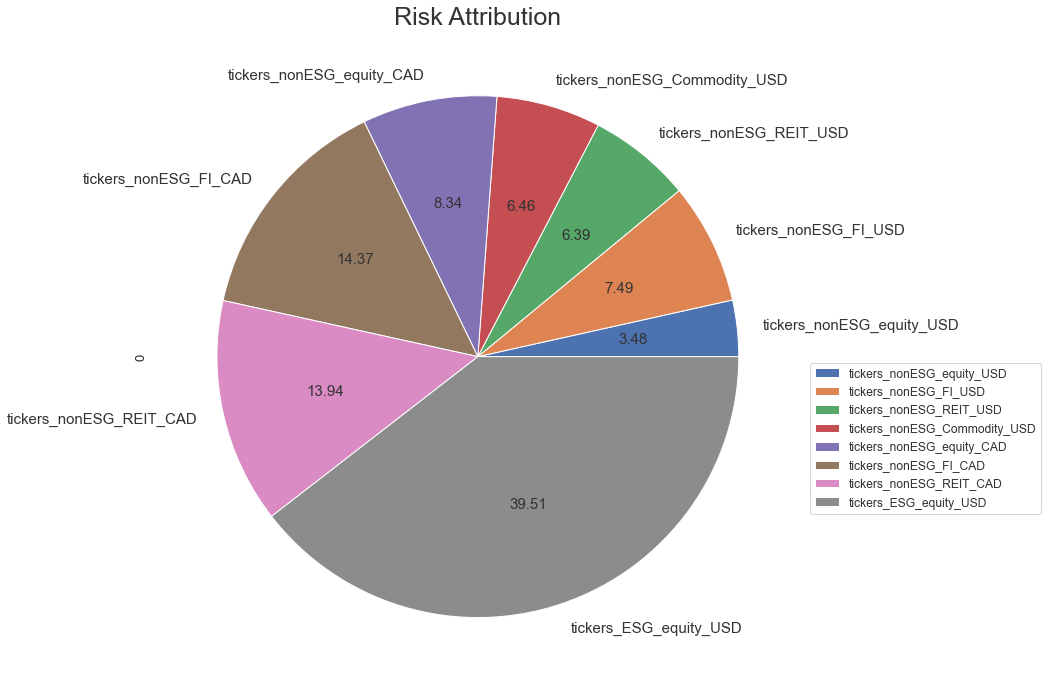

In [351]:
#Risk Attribution
price_portf_1y = price_portf.loc[testDate]  # ETF price for the test period
price_portf_1y = price_portf_1y.pct_change()  # ETF monthly return for the test period
price_portf_1y = price_portf_1y.iloc[1:]
cov_matrix_1y = price_portf_1y.cov()
cov_matrix_1y_mtx = cov_matrix_1y.to_numpy()  # ETF monthly return variance-covariance matrix
latest_weight = weights.iloc[-1]  # the weight for each asset of the last rebalancing period
# calculate the risk contribution of each ETF to the portfolio risk
risk_contribution = calculate_risk_contribution(latest_weight, cov_matrix_1y_mtx)  
risk_contribution = risk_contribution / np.sum(calculate_risk_contribution(latest_weight, cov_matrix_1y_mtx))
risk_contribution = pd.DataFrame(np.array(risk_contribution).T, columns = tickers)
# seperate the risk contribution into asset classes
rc_asset_class = pd.DataFrame()
rc_asset_class["tickers_nonESG_equity_USD"] = risk_contribution[tickers_nonESG_equity_USD].sum(axis=1)
rc_asset_class["tickers_nonESG_FI_USD"] = risk_contribution[tickers_nonESG_FI_USD].sum(axis=1)
rc_asset_class["tickers_nonESG_REIT_USD"] = risk_contribution[tickers_nonESG_REIT_USD].sum(axis=1)
rc_asset_class["tickers_nonESG_Commodity_USD"] = risk_contribution[tickers_nonESG_Commodity_USD].sum(axis=1)
rc_asset_class["tickers_nonESG_equity_CAD"] = risk_contribution[tickers_nonESG_equity_CAD].sum(axis=1)
rc_asset_class["tickers_nonESG_FI_CAD"] = risk_contribution[tickers_nonESG_FI_CAD].sum(axis=1)
rc_asset_class["tickers_nonESG_REIT_CAD"] = risk_contribution[tickers_nonESG_REIT_CAD].sum(axis=1)
rc_asset_class["tickers_ESG_equity_USD"] = risk_contribution[tickers_ESG_equity_USD].sum(axis=1)

print ("###################Risk Attribution###################")
riskAttribution = rc_asset_class.T
print (round(riskAttribution*100,2))
riskAttribution.plot.pie(autopct='%.2f',fontsize=15, figsize=(15, 12),subplots=True)
plt.title("Risk Attribution",fontsize=25)
plt.legend(loc='upper left', bbox_to_anchor=(1, 0.5))
plt.show()

###################Return Attribution###################
                                  0
tickers_nonESG_equity_USD      0.19
tickers_nonESG_FI_USD         10.16
tickers_nonESG_REIT_USD        0.95
tickers_nonESG_Commodity_USD   1.94
tickers_nonESG_equity_CAD      2.38
tickers_nonESG_FI_CAD         58.61
tickers_nonESG_REIT_CAD        8.57
tickers_ESG_equity_USD        17.19


<ipython-input-352-edc6b1fcd1b8>:8: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  returnAttr=pd.Series()


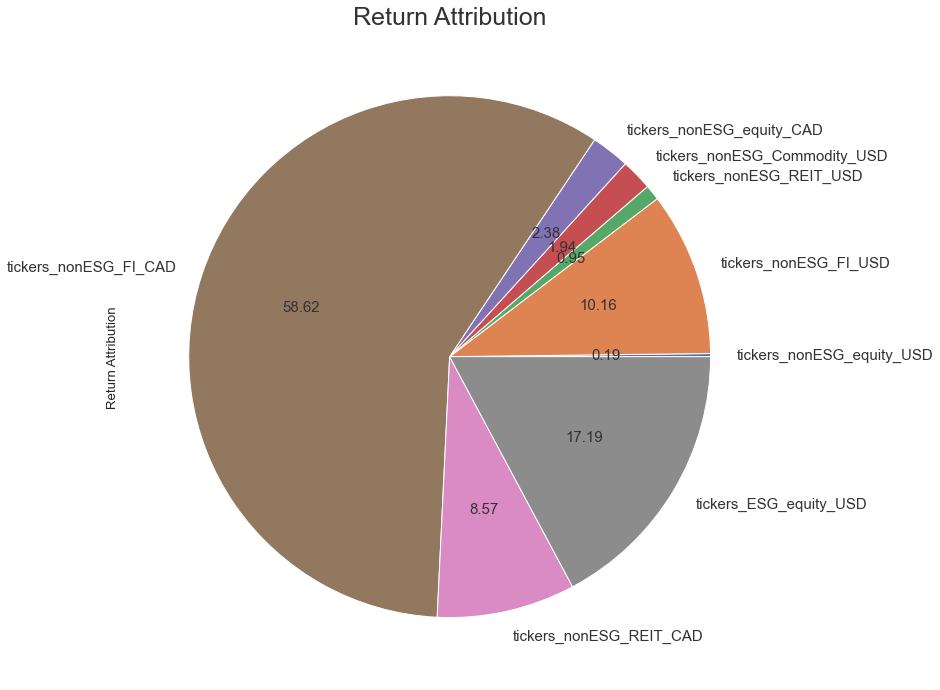

In [352]:
#Return Attribution Version 2 - consider injection
df_pfv_rb = df_pfv.loc[testDate2]
weights = weights.set_index(testDate2)
df_pfv_asset = weights.mul(df_pfv_rb.iloc[:,0], axis=0)
tickerAll = tickers_nonESG_equity_USD + tickers_nonESG_FI_USD + tickers_nonESG_REIT_USD + tickers_nonESG_Commodity_USD +  tickers_nonESG_equity_CAD + tickers_nonESG_FI_CAD + tickers_nonESG_REIT_CAD + tickers_ESG_equity_USD 
moneyAdd=[(df_pfv_asset.loc[testDate2[i]:testDate2[i+1],tickerAll].iloc[-2]*-df_pfv_asset.loc[testDate2[i]:testDate2[i+1],tickerAll].iloc[0]) for i in range(len(testDate2)-1)]
moneyAdd=pd.DataFrame(moneyAdd)
returnAttr=pd.Series()
returnAttr['tickers_nonESG_equity_USD']=moneyAdd[tickers_nonESG_equity_USD].sum().sum()
returnAttr['tickers_nonESG_FI_USD']=moneyAdd[tickers_nonESG_FI_USD].sum().sum()
returnAttr['tickers_nonESG_REIT_USD']=moneyAdd[tickers_nonESG_REIT_USD].sum().sum()
returnAttr['tickers_nonESG_Commodity_USD']=moneyAdd[tickers_nonESG_Commodity_USD].sum().sum()
returnAttr['tickers_nonESG_equity_CAD']=moneyAdd[tickers_nonESG_equity_CAD].sum().sum()
returnAttr['tickers_nonESG_FI_CAD']=moneyAdd[tickers_nonESG_FI_CAD].sum().sum()
returnAttr['tickers_nonESG_REIT_CAD']=moneyAdd[tickers_nonESG_REIT_CAD].sum().sum()
returnAttr['tickers_ESG_equity_USD']=moneyAdd[tickers_ESG_equity_USD].sum().sum()
returnAttr["Return Attribution"]=returnAttr*(portfValue_wocf[-1]-100000-10000*10)/returnAttr.sum()

print ("###################Return Attribution###################")
df = returnAttr["Return Attribution"]
df= (round((df/df.sum())*100,2))
df=pd.DataFrame(df)
print (df)
df.columns=["Return Attribution"]
df["Return Attribution"].plot.pie(autopct='%.2f', fontsize=15, figsize=(12, 12))
plt.title("Return Attribution",fontsize=25)
plt.show()